# Import Package

In [1]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

2022-06-09 21:08:14.172161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 21:08:14.172199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.22.4,
1.4.2,
2.9.1


In [3]:
!python --version

Python 3.8.10


# Import Dataset

In [10]:
rating = pd.read_csv('../../data/rating.csv')
hotel = pd.read_csv('../../data/hotel.csv')
user = pd.read_csv('../../data/user.csv')

In [11]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'hotel : {hotel.shape}')
print(f'user : {user.shape}')

rating : (10000, 3)
hotel : (110, 11)
user : (300, 3)


# Persiapan Dataset

In [12]:
# Merubah data agar hanya dari Kota Yogyakarta

hotel = hotel[hotel['City']=='Yogyakarta']
hotel.head()

,id,Name,City,Ratings,Price,Addres,Coordinate,Description,Lat,Long,Images
0,1,Artotel Suites Bianti Yogyakarta,Yogyakarta,5.0,625000,"Jl. Urip Sumoharjo No.37, Klitren, Kec. Gondok...","-7.782655534201323, 110.38190546790418",Set among shops in the city center and offerin...,-7.782656,110.381906,https://asset.kompas.com/crops/bcek5vqNPwTfaEL...
1,2,The Phoenix Hotel Yogyakarta - MGallery Collec...,Yogyakarta,4.5,735390,"Jl. Jend. Sudirman No.9, Cokrodiningratan, Kec...","-7.782368072882206, 110.36852501265078","Set in a colonial building dating from 1918, t...",-7.782368,110.368525,https://cf.bstatic.com/xdata/images/hotel/max1...
2,3,Hotel New Saphir Yogyakarta,Yogyakarta,3.5,398160,"Jl. Laksda Adisucipto No.38, Demangan, Kec. Go...","-7.783321134572196, 110.3914155390688","This chic, palm-tree fronted hotel with views ...",-7.783321,110.391415,https://s-light.tiket.photos/t/01E25EBZS3W0FY9...
3,4,Lafayette Boutique Hotel Yogyakarta,Yogyakarta,4.5,649366,"Manggung, Caturtunggal, Kec. Depok, Kabupaten ...","-7.759268574181231, 110.38734472557458","In a bustling commercial area, this upscale, s...",-7.759269,110.387345,https://ik.imagekit.io/tvlk/apr-asset/dgXfoyh2...
4,5,Grand Mercure Yogyakarta Adi Sucipto,Yogyakarta,4.5,532784,"Jl. Laksda Adisucipto No.80, Demangan Baru, Ca...","-7.783529869615401, 110.39236054584215",Set in a commercial area and offering views of...,-7.783530,110.392360,https://cf.bstatic.com/xdata/images/hotel/max1...


In [13]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [14]:
df = rating.copy()

In [15]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [16]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [17]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [18]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [19]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah Hotel : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah Hotel : 437
Rating minimum : 1.0
Rating maximum : 5.0


In [20]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,207,3.0,187,262
4684,142,268,2.0,141,83
1731,54,103,3.0,53,10
4742,144,119,3.0,143,141
4521,138,288,5.0,137,283


# Splitting Dataset

In [21]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [22]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [23]:
model = Recommended(num_users, num_place, 50)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
              )

2022-06-09 21:13:16.371077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 21:13:16.371131: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 21:13:16.371167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wan): /proc/driver/nvidia/version does not exist


# training Model

In [24]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 50,
    validation_data = (x_test, y_test)
)

Epoch 1/50
250/250 [==============================] - 2s 4ms/step - loss: 0.6998 - accuracy: 0.1840 - val_loss: 0.7010 - val_accuracy: 0.1825
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6968 - accuracy: 0.1964 - val_loss: 0.6998 - val_accuracy: 0.1870
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6957 - accuracy: 0.2004 - val_loss: 0.7001 - val_accuracy: 0.1945
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6971 - accuracy: 0.2111 - val_loss: 0.6996 - val_accuracy: 0.1915
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6920 - accuracy: 0.2148 - val_loss: 0.6983 - val_accuracy: 0.1920
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.2195 - val_loss: 0.6979 - val_accuracy: 0.1950
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.6898 - accuracy: 0.2212 - val_loss: 0.6986 - val_accuracy: 0.1990
Epoch 

# Evaluasi Model

In [25]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7063 - accuracy: 0.2025


[0.7063391208648682, 0.20250000059604645]

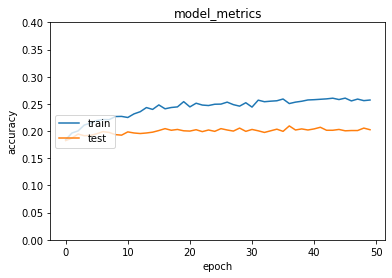

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_metrics')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [27]:
hotel.columns

Index(['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images'],
      dtype='object')

In [28]:
place_df = hotel[['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images']]
place_df.columns = ['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images']
df = rating.copy()

In [29]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [30]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [31]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Name, '\n    ', row.Addres, ',', 'Harga Tiket Masuk ', row.Price, ',', 'Rating Wisata ', row.Ratings,'\n')

print('==='*15)

2/2 [==============================] - 0s 7ms/step

------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Artotel Suites Bianti Yogyakarta 
     Jl. Urip Sumoharjo No.37, Klitren, Kec. Gondokusuman, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55222 , Harga Tiket Masuk  625000 , Rating Wisata  5.0 

2 . Grand Mercure Yogyakarta Adi Sucipto 
     Jl. Laksda Adisucipto No.80, Demangan Baru, Caturtunggal, Sleman, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55281 , Harga Tiket Masuk  532784 , Rating Wisata  4.5 

3 . Hotel Indah Palace Yogyakarta 
     Jl. Sisingamangaraja No.74, Brontokusuman, Kec. Mergangsan, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55153 , Harga Tiket Masuk  327826 , Rating Wisata  3.5 

4 . Hotel Surya Putri by RedDoorz 
     Jl. Tukangan No.29, Tegal Panggung, Kec. Danurejan, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55212 , Harga Tiket Masuk  nan , Rating Wisata  3.

# Save Model

In [36]:
filename = '../../model/hotel_jogyakarta.pkl'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://f7f96333-cea4-4e82-8d8a-527081255d84/assets


In [37]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7063 - accuracy: 0.2025
